In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from src.object_detection import ObjectDetector, OnnxObjectDetector

image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
# image = Image.open("../datasets/SVHN/examples/5.png")

image_ = np.asarray(image)
image_ = image_[100:-50, 40:-50]

yolo_model = YOLO("../models/best.pt")

---
# **Preprocessing**

In [ ]:
# img = img[..., :input_c]                                                                # V
# img_h, img_w, img_c = img.shape                                                         # V

# aspect_ratio = img_w / img_h                                                            # V
# if aspect_ratio > 1:                                                                    # V
#     new_img_h = int(input_w / aspect_ratio)                                             # V
#     new_img_w = input_w                                                                 # V
# else:                                                                                   # V
#     new_img_h = input_h                                                                 # V
#     new_img_w = int(input_h / aspect_ratio)                                             # V
    
# resized_img = cv2.resize(img, (new_img_w, new_img_h), interpolation=cv2.INTER_LINEAR)   # V

# padded_img = np.ones((input_h, input_w, img_c)) * fill_value                            # V
# left = (input_w - new_img_w) // 2                                                       # V
# bottom = (input_h - new_img_h) // 2                                                     # V

# padded_img[bottom : bottom + new_img_h, left : left + new_img_w] = resized_img          # V
# pad_top = (input_h - new_img_h) // 2                                                    # V
# pad_left = (input_w - new_img_w) // 2                                                   # V
# pad_bottom = input_h - pad_top                                                          # V
# pad_right = input_w - pad_left                                                          # V

# padded_img = padded_img / 255.0                                                         # V
# padded_img = padded_img.transpose(2, 0, 1)                                              # V
# input_tensor = padded_img.astype(np.float32)                                            # V
# input_tensor = np.expand_dims(img, 0).astype(np.float32)                                # V

In [46]:
from src.onnx_preprocessing import create_onnx_preprocessing

create_onnx_preprocessing("preprocessing.onnx")
preprocessing = ort.InferenceSession("preprocessing.onnx", providers=["CPUExecutionProvider"])

INPUT_H = 256
INPUT_W = 256
FILL_VALUE = 114

inputs = {
    "image": image_, 
    "input_h": np.array([INPUT_H], dtype=np.int32), 
    "input_w": np.array([INPUT_W], dtype=np.int32),
    "fill_value": np.array([FILL_VALUE], dtype=np.uint8)
}
preprocessed_img, padding_tlbr = preprocessing.run(None, inputs)

---
# **Detection**

In [ ]:
IMGSZ = 256

detection_model = YOLO("../models/best.pt")
detection_model.export(format="onnx", imgsz=IMGSZ)

---
# **NonMaxSupression**

In [ ]:
# outputs_transposed = yolo_outputs.transpose(0, 2, 1)            # V

# boxes_xywh = outputs_transposed[..., :4]                        # V
# class_scores = outputs_transposed[..., 4:]                      # V

# scores = class_scores.max(axis=2, keepdims=True)                # V
# scores = scores.transpose(0, 2, 1)                              # V

# class_ids = class_scores.argmax(axis=2).squeeze()               # V

# iou_threshold = 0.7                                             # V
# score_threshold = 0.25                                          # V
# max_output_boxes_per_class = 100                                # V

# selected_idxs = nms(                                            # V
#     boxes_xywh, 
#     class_scores,
#     max_output_boxes_per_class,
#     iou_threshold,
#     score_threshold
# )

# selected_boxes = boxes_xywh[selected_idxs]                      # V
# selected_class_scores = scores[selected_idxs]                   # V
# selected_class_ids = class_ids[selected_idxs]                   # V

In [45]:
from src.onnx_nms import create_onnx_NMS

outputs = np.random.randn(1, 14, 1344).astype(np.float32)
create_onnx_NMS(filepath="nms.onnx", opset=18)
nms = ort.InferenceSession("nms.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

CONF_THRESHOLD = 0.25
IOU_THRESHOLD = 0.7
MAX_OUTPUT_BOXES_PER_CLASS = 100

nms_results = nms.run(
    ["selected_boxes_xywh", "selected_class_scores", "selected_class_ids"], 
    {
        "output0": outputs, 
        "max_output_boxes_per_class": np.array([MAX_OUTPUT_BOXES_PER_CLASS], dtype=np.int32),
        'iou_threshold': np.array([IOU_THRESHOLD], dtype=np.float32), 
        'score_threshold': np.array([CONF_THRESHOLD], dtype=np.float32)
    }
)
selected_boxes_xywh, selected_class_scores, selected_class_ids = nms_results

---
# **Complete ONNX Object Detector**

In [3]:
# image = Image.open("../datasets/yolo_HWD+/images/test/42.png")
image = Image.open("../datasets/SVHN/examples/5.png")
image_ = np.asarray(image)[..., :3]

In [4]:
onnx_detector = OnnxObjectDetector(
    preprocessing_path="../models/preprocessing.onnx", 
    yolo_path="../models/detection_model.onnx",
    nms_path="../models/nms.onnx"
)

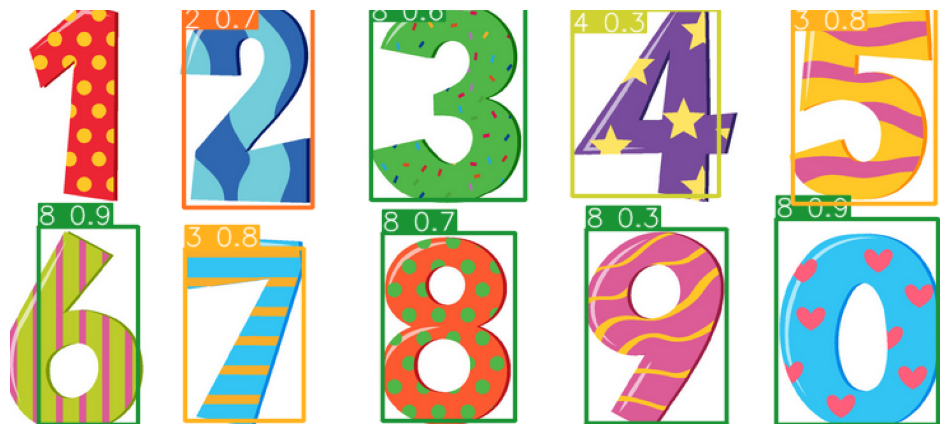

In [5]:
_ = onnx_detector(image_).visualize(plot=True)

[[       21.7      86.383       27.58      54.139]
 [     233.38       85.24      44.811      56.195]
 [     64.867       88.97      32.899      47.274]
 [     234.97       26.18      39.496      54.231]
 [     120.68      86.805      36.651      51.166]
 [     65.671      26.589      35.421       55.24]
 [      120.8      24.625      42.504      55.438]
 [     177.95      86.564      38.741      53.072]
 [        175      25.454      40.492      51.305]]


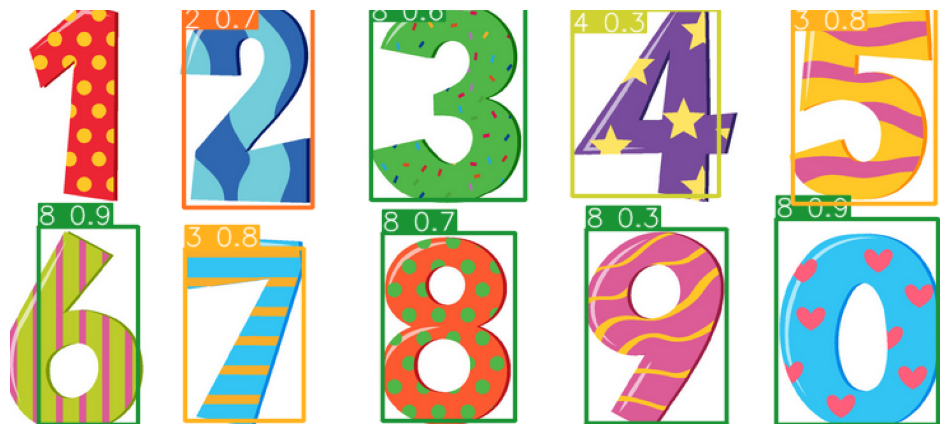

In [8]:
_ = onnx_detector(image_).visualize(plot=True)

---
# **Python Object Detector**

In [9]:
detector = ObjectDetector("../models/detection_model.onnx")

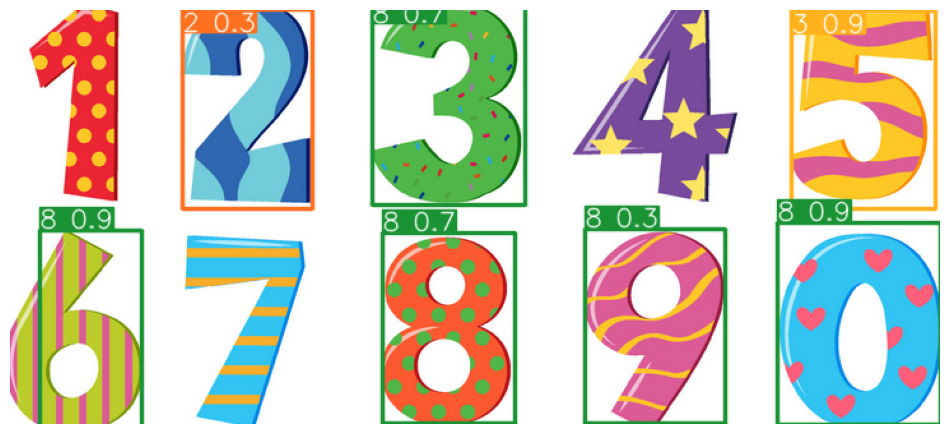

In [11]:
_ = detector(image_, 0.7, 0.25).visualize(plot=True)

# **Measuring time**

In [12]:
%timeit detector(image_, 0.7, 0.25).visualize()

5.43 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit onnx_detector(image_, 0.7, 0.25).visualize()

7.85 ms ± 720 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# class Postprocessing(BasePostprocessing):
#     def __call__(
#         self, input_h: int, input_w: int, boxes_xywh: np.ndarray, padding_tlbr: np.ndarray
#     ):
#         pad_top, pad_left, pad_bottom, pad_right = padding_tlbr
#         boxes_xywh -= [pad_left, pad_top, 0, 0]
#         pad_y = pad_top + pad_bottom
#         pad_x = pad_left + pad_right
#         h = input_h - pad_y
#         w = input_w - pad_x
#         boxes_xywhn = boxes_xywh / [w, h, w, h]
#         return {"boxes_xywhn": boxes_xywhn}

In [25]:
import onnx_graphsurgeon as gs
import onnx
import onnxruntime as ort
from src.create_onnx_model.preprocessing import concat, _const, get_item, sub, add, div, cast

In [36]:
graph = gs.Graph(opset=18)

INT32 = np.int32
INT64 = np.int64
UINT8 = np.uint8
FLOAT32 = np.float32
BOOL = np.bool_
STR = np.str_

boxes_xywh = gs.Variable(name="boxes_xywh", dtype=FLOAT32, shape=("num_boxes", 4))
input_h = gs.Variable(name="input_h", dtype=INT32, shape=(1,))
input_w = gs.Variable(name="input_w", dtype=INT32, shape=(1,))
padding_tlbr = gs.Variable(name="padding_tlbr", dtype=INT32, shape=(4,))

inputs = [boxes_xywh, input_h, input_w, padding_tlbr]
graph.inputs = inputs

pad_top = graph.get_item(padding_tlbr, axis=0, idx=0, name="pad_top", shape=(1,))
pad_left = graph.get_item(padding_tlbr, axis=0, idx=1, name="pad_left", shape=(1,))
pad_bottom = graph.get_item(padding_tlbr, axis=0, idx=2, name="pad_bottom", shape=(1,))
pad_right = graph.get_item(padding_tlbr, axis=0, idx=3, name="pad_right", shape=(1,))


scalar_0 = _const("scalar_0", 0, dtype=INT32)
boxes_subtractor_int = graph.concat(
    [pad_left, pad_top, scalar_0, scalar_0], 
    axis=0, 
    name="boxes_subtractor_int", 
    shape=(4,)
)
boxes_subtractor = graph.cast(boxes_subtractor_int, dtype=FLOAT32, name="boxes_subtractor", shape=(4,))
boxes_xywh_no_pad = graph.sub(boxes_xywh, boxes_subtractor, name="boxes_xywh_no_pad", shape=("num_boxes", 4))

pad_y = graph.add(pad_top, pad_bottom, name="pad_y", shape=(1,))
pad_x = graph.add(pad_left, pad_right, name="pad_x", shape=(1,))

orig_img_h = graph.sub(input_h, pad_y, name="orig_img_h", shape=(1,))
orig_img_w = graph.sub(input_w, pad_x, name="orig_img_w", shape=(1,))

boxes_xywh_divider_int = graph.concat(
    [orig_img_w, orig_img_h, orig_img_w, orig_img_h], 
    axis=0, 
    name="boxes_xywh_divider_int", 
    shape=(4,)
)
boxes_xywh_divider = graph.cast(boxes_xywh_divider_int, dtype=FLOAT32, name="boxes_xywh_divider", shape=(4,))

boxes_xywhn = graph.div(boxes_xywh, boxes_xywh_divider, name="boxes_xywhn", shape=("num_boxes", 4))

graph.outputs = [boxes_xywhn]
onnx.save(gs.export_onnx(graph), "postprocessing.onnx")

In [37]:
session = ort.InferenceSession("postprocessing.onnx", providers=["CPUExecutionProvider"])

In [38]:
preprocessed = detector._preprocess(np.asarray(image))
preprocessed_img, padding_tlbr = (
    preprocessed["preprocessed_img"],
    preprocessed["padding_tlbr"],
)
# add batch dim
preprocessed_img = np.expand_dims(preprocessed_img, 0).astype(np.float32)
yolo_output = detector._detect(preprocessed_img)
output0 = yolo_output["output0"]
selected_output = detector._nms(
    output0=output0,
    max_output_boxes_per_class=100,
    iou_threshold=0.7,
    score_threshold=0.25,
)
boxes_xywh, class_scores, class_ids = (
    selected_output["selected_boxes_xywh"],
    selected_output["selected_class_scores"],
    selected_output["selected_class_ids"],
)

In [40]:
session.run(
    ["boxes_xywhn"], 
    {
        "boxes_xywh": boxes_xywh,
        "input_h": np.array([detector.yolo.input_h], dtype=INT32),
        "input_w": np.array([detector.yolo.input_w], dtype=INT32),
        "padding_tlbr": np.array(padding_tlbr, dtype=INT32)
    }
)[0]

array([[   0.086875,      1.3993,     0.11026,     0.47199],
       [    0.91839,      0.8714,     0.15534,     0.47832],
       [     0.9124,      1.3879,     0.17539,     0.48778],
       [    0.47161,     0.85375,     0.16503,     0.49836],
       [    0.47128,      1.4002,     0.14364,     0.45917],
       [    0.25513,     0.86915,     0.13987,     0.48484],
       [     0.6942,      1.3944,     0.15149,     0.46978]], dtype=float32)

In [42]:
detector._postprocess(boxes_xywh, padding_tlbr)['boxes_xywhn']

array([[   0.086875,     0.14267,     0.11026,     0.47199],
       [    0.91839,    -0.38524,     0.15534,     0.47832],
       [     0.9124,     0.13123,     0.17539,     0.48778],
       [    0.47161,    -0.40289,     0.16503,     0.49836],
       [    0.47128,     0.14358,     0.14364,     0.45917],
       [    0.25513,    -0.38749,     0.13987,     0.48484],
       [     0.6942,     0.13773,     0.15149,     0.46978]])